#NAML Project 4

## Credit card fraud detection


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the dataset

In [60]:
dataset = pd.read_csv('creditcard.csv')
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Check if there are missing entries

In [61]:
dataset.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Remove records with missing entries 

In [62]:
dataset = dataset.dropna()
dataset.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Data Inspection

In [63]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [66]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


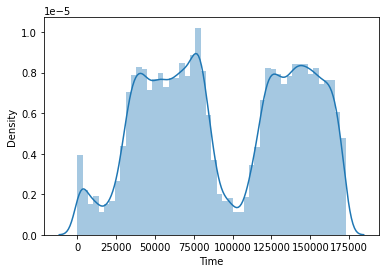

In [68]:
sns.distplot(dataset['Time'])

In [69]:
dataset.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,2.438580e-16,2.422086e-16,-2.115458e-16,9.352582e-16,-3.252451e-16,6.308789e-16,-5.011524e-16,2.870125e-16,1.818128e-16,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,9.468995e-16,-6.588252e-16,3.854521e-16,-2.541036e-16,2.831060e-16,4.934097e-17,-9.883008e-16,2.636654e-16,9.528280e-17,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,-5.501758e-17,2.206522e-16,-6.883375e-16,4.271336e-16,1.122756e-16,1.183364e-15,4.576619e-17,5.427965e-16,2.576773e-16,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,-2.083600e-16,-5.657963e-16,-1.506129e-16,-8.522435e-17,-1.507718e-16,-6.939204e-16,-4.397925e-16,1.493667e-16,-2.656938e-16,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447
V5,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,-6.601716e-16,7.342759e-16,3.761033e-16,-9.578659e-16,-3.634803e-16,-5.132620e-16,-3.517076e-16,1.425729e-16,1.109525e-15,-3.138234e-16,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,-0.094974
V6,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,2.850776e-16,4.865799e-16,2.140589e-16,-2.268061e-16,3.452801e-16,-6.368111e-18,-2.477917e-16,3.567582e-16,2.811474e-16,2.717167e-16,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,-0.043643
V7,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,3.043333e-17,-1.084105e-15,1.510045e-15,-9.892325e-17,-1.729462e-16,1.936832e-17,2.893672e-16,1.149692e-15,-1.116789e-16,-2.874017e-16,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.187257
V8,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,9.051847e-17,1.954747e-16,-6.266057e-17,-2.382948e-16,-1.131098e-16,2.021491e-16,5.027192e-16,-3.508777e-16,-4.093852e-16,-5.339821e-16,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,0.019875
V9,-0.008660,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,-2.771761e-16,4.682341e-16,-2.445230e-15,-2.650351e-16,2.343317e-

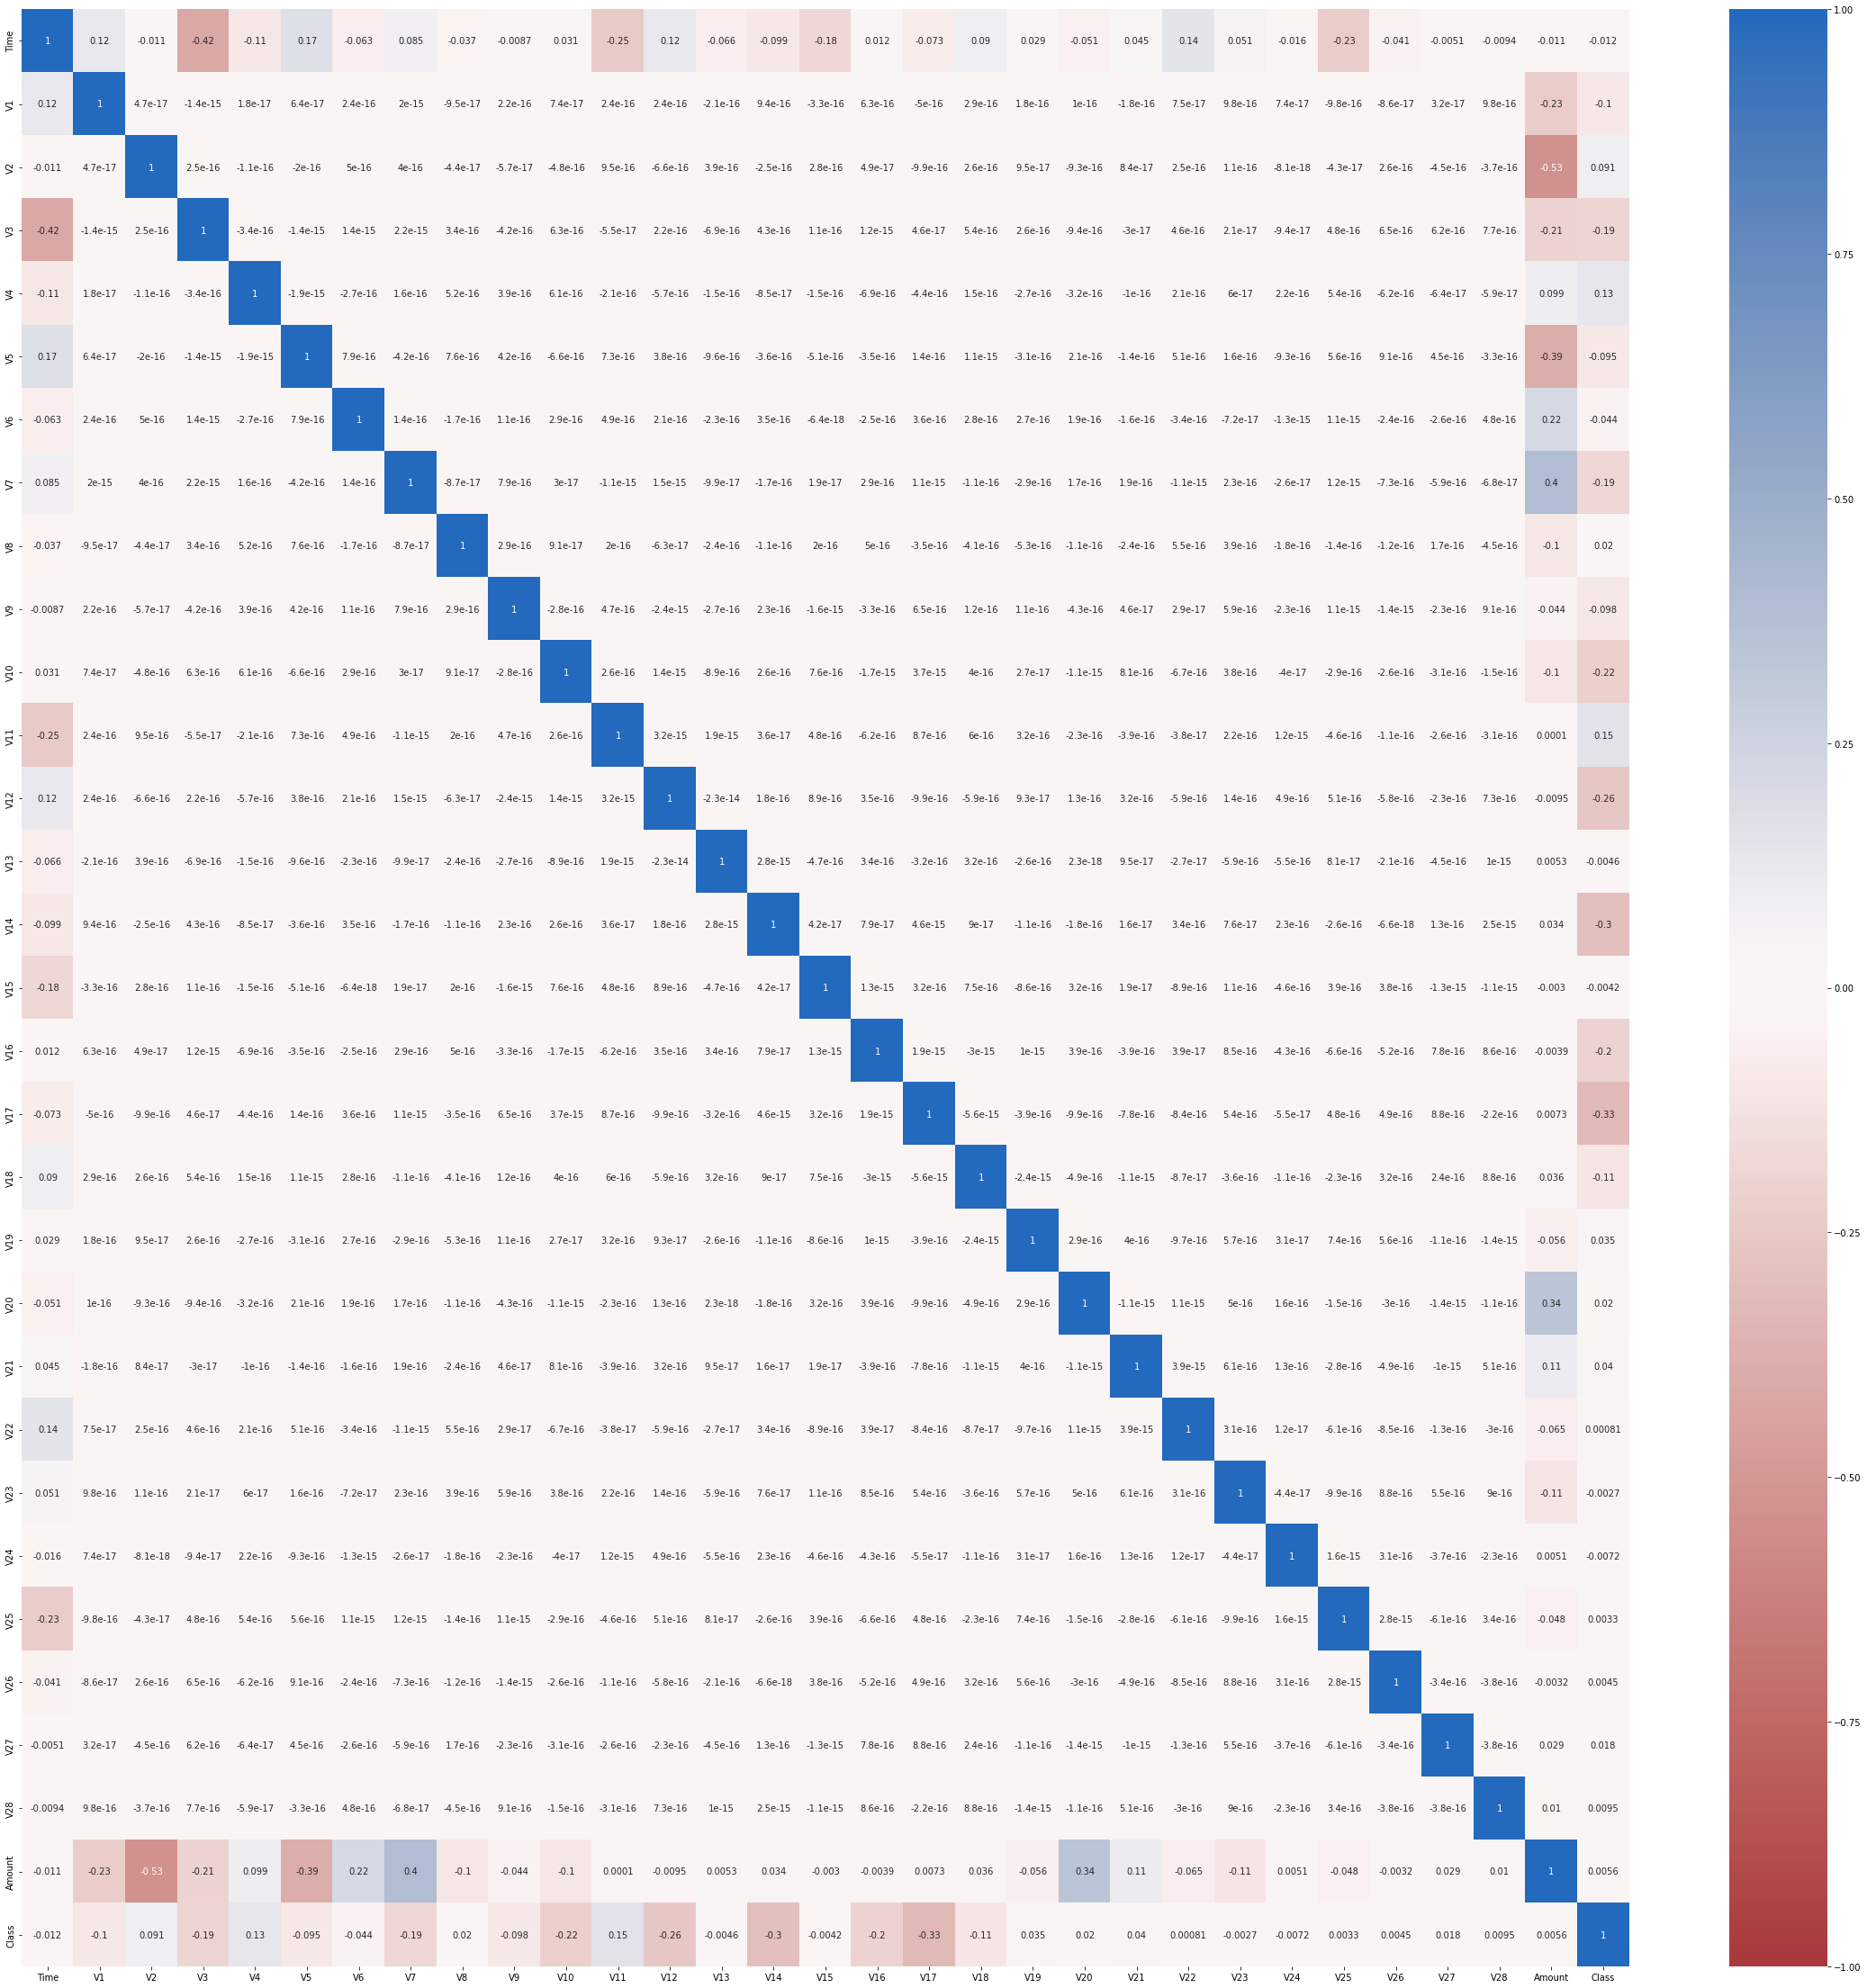

In [70]:
fig, ax = plt.subplots(figsize=(40,40))   
sns.heatmap(dataset.corr(),ax = ax,  annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)


## Data Normalization

In [87]:
data_mean = dataset.mean()
data_std = dataset.std()
data_normalized = (dataset - data_mean) / data_std

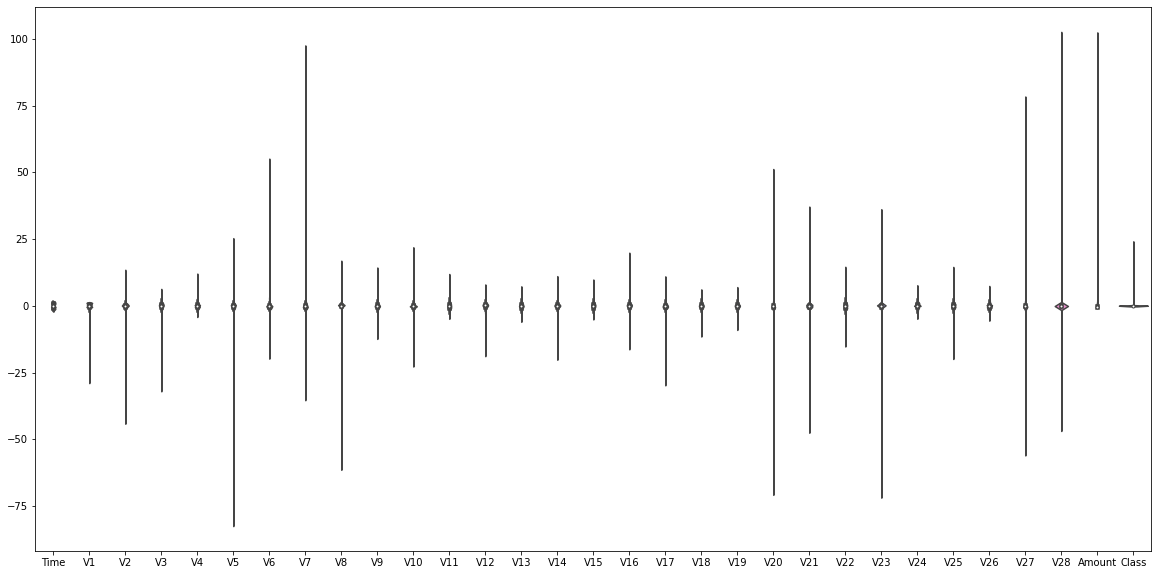

In [88]:
_, ax = plt.subplots(figsize=(20,10))
sns.violinplot(data = data_normalized, ax = ax)

## Train-validation split


Shuffle the data using the np.random.shuffle function and split the data as follows:

put 70% in the train dataset

put 30% in the validation dataset

In [151]:
data_normalized_np = dataset.to_numpy()

np.random.seed(0)
np.random.shuffle(data_normalized_np)
      
fraction_validation = 0.3

num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))

train_set = data_normalized_np[:num_train,:]
valid_set = data_normalized_np[num_train:,:]

print('train set size     : %d' % train_set.shape[0])
print('validation set size: %d' % valid_set.shape[0])

train set size     : 199364
validation set size: 85443


## Random under-sampling

In [153]:
print('Database: ')
print('Number of fraud transactions     : %d' % sum(dataset["Class"]))
print('Number of non-fraud transactions : %d' % sum(dataset["Class"] == 0))
print('Number of transactions           : %d' % dataset["Class"].shape[0])

print('\nTraining set: ')
print('Number of fraud transactions     : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]  == 0))
print('Number of transactions           : %d' % train_set.shape[0])

print('\nTest set: ')
print('Number of fraud transactions     : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1] == 0))
print('Number of transactions           : %d' % valid_set.shape[0])

Database: 
Number of fraud transactions     : 492
Number of non-fraud transactions : 284315
Number of transactions           : 284807

Training set: 
Number of fraud transactions     : 337
Number of non-fraud transactions : 199027
Number of transactions           : 199364

Test set: 
Number of fraud transactions     : 155
Number of non-fraud transactions : 85288
Number of transactions           : 85443


Shuffle the data using the np.random.shuffle function and split the data by ratio (X) : (100-X)

In [167]:
def RUS(ratio):

  train_fraud = train_set[train_set[:,data_normalized_np.shape[1]-1] == 1]
  train_not_fraud = train_set[train_set[:,data_normalized_np.shape[1]-1] == 0]

  num_not_fraud_reduced = int((train_fraud.shape[0] * (100-ratio)) / ratio)

  np.random.seed(0)
  np.random.shuffle(train_not_fraud)

  train_not_fraud_reduced = train_not_fraud[:num_not_fraud_reduced,:]

  return [train_fraud, train_not_fraud_reduced]